Ideal Solution: Some way to get matrix inverses more efficently


Notes:
What if approximation was very skinny?
Problem is that for 2nd order matrix you can't even create all weights in memory; O(N^2) is too large not even doing the inverse. You're not even approximating H but Hv.

What's the runtime of turning nxn matrix into nxk?
1.   O(N^2 k) for svd/pca/qr decomposition to O(n²log(k)) for truncated svd.
2. Just Project data onto random k-dimensional subspace is 50x speed up emperically.
3. Sketching: Use hash functions to create compressed representations.  O(n²z(A)) up to 200x speedup.



*Need some way for iterative improvement*. Just doing 1 fast approx is a nice idea but real value is in being able to scale up.


List of all ideas:

1. A=P.T@D@P, A.T@A=P.T@D^2@P, it seems like with a few samples we could estimate D from the difference in D and D^2 and for certain sizes that would be a lot faster
  2. So we pick a bunch of random v's to sample, sort by how large the distance in Av and A.TAv is, and then project out on the largest to estimate the eigenvalues and eigenvectors.
   fit a pareto distribution to the eigenvalues, which when combined with the trace (sum of eigenvalues/diagonal entries) lets us know when we've found all of the "largest" eigenvalues.
  3.  fit a pareto distribution to the eigenvalues, which when combined with the trace (sum of eigenvalues/diagonal entries) lets us know when we've found all of the "largest" eigenvalues.
  4. Somehow have to approx A as nxk for any real speedup

1b. Again for very skinny matrix. AA.T  is kxk symetric postive and has eigenvalues/vectors. A^(2k)v = sum λ^2kv. Exponentiate matrix a few times, {A^2i for i in range(...) } and fit for eigenvalues against vectors? Using FFT/Laplacian for predicting effects on polynomials? But problem is you're mixing up effects of eigenvectors.
  2. But why do I care about getting the eigenvalues?
  3. from eigenvalues you know singular values of inverse, why's that helpful?
  4. Am I computing eigenvectors of larger dim or smaller dim?

3. Use trace to estimate size of elements, then somehow normalize? Transpose and inverse of central elements how does that work? Is there a way to check for directions which have largest “rotations” (just eigenvectors) and account for those directly
  2. Assunmes that A=USV, A^T = V.T S.T U.T; Assuming in high dim that most vectors are uncorrelated, Then x=Av can be solved by Transposing matrix and taking inverse of diagonal elements? if A is diagonal then only need to change diagonal. Assuming in high-d A is basically diagonal, so if adjusted true signular values then would have inverse. We can aprox true singular values by just using existing diagonal entries. x=Ab can be solved in as much time as Ab. What happens if keep applying this process? (Practically don't you run into row v column having massive performance differences?)



Just start doing basic sim of comparisions and performance?




# Testing For Idea 1b - square then binary expansion then fit polynomial

but eigenvalues of skinny matrix are O(nk^2 + k^3): multiply and then compute eigenvalues explicitly. I'm trying to approx with O(nk^2 + c*k^3)?

And not enough that A^K becomes axis aligned; also needs to become axis aligned wrt standard basis. Even if it's eigen-basis was just a permutation of the standarded basis because we have an ording when approximating trace can't assume this just goes away

In [ ]:
import numpy as np
size=500

A= np.random.rand(5*size, size//5)
sq = A @ A.T
squares = {1:sq}
for i in range(2,10):
  # else get's "more and more square"
  squares[i] = sq.T @sq

# What approximation solves sum_i (s_i**k)? Not a good one?


In [7]:
# Check how symmetric A.TA actually is
#
import numpy as np

# Initialize
size = 500
A = np.random.rand(5*size, size//5)
sq = A @ A.T
squares = {1: sq}
squares_rotated = {1: sq}

# Function to compute the orthonormality deviation
def orthonormality_deviation(M):
    return np.linalg.norm(M.T @ M - np.eye(M.shape[0]), 'fro')

# Function to compute cosine similarity and angles between eigenvectors and standard basis
def eigen_basis_alignment(Vt):
    # Compute the eigenvectors (using SVD)
    U, _, Vt = np.linalg.svd(A)
    # magnitude of change of basis matrix
    return [(np.linalg.norm(U, 'fro'), np.linalg.norm(Vt, 'fro'))]

    num_vectors = Vt.shape[0]
    alignment_info = []
    for i in range(num_vectors):
        # Standard basis vector e_i (just the i-th unit vector)
        e_i = np.zeros(num_vectors)
        e_i[i] = 1

        # Eigenvector corresponding to the i-th row of Vt (which represents the eigenbasis)
        v_i = Vt[i, :]

        # Cosine similarity
        cosine_similarity = np.dot(v_i, e_i) / (np.linalg.norm(v_i) * np.linalg.norm(e_i))

        # Angle (in radians)
        angle = np.arccos(cosine_similarity)  # Note: np.arccos returns value between 0 and pi

        alignment_info.append((cosine_similarity, angle))

    return alignment_info

# Compute squares and rotated squares
for i in range(2, 10):
    squares[i] = squares[i-1].T @ squares[i-1]
    squares_rotated[i] = squares_rotated[i-1] @ squares_rotated[i-1]

# Print the magnitudes of how far each matrix is from orthonormality
print("Deviations from orthonormality for squares:")
for i in range(1, 10):
    print(f"Square {i}: {orthonormality_deviation(squares[i])}")

    # Get alignment info
    alignment_info = eigen_basis_alignment(squares[i])
    print('cos sim', np.sum([abs(cos_sim) for i, (cos_sim, angle) in enumerate(alignment_info)]))
    print('angle', np.sum([abs(angle) for i, (cos_sim, angle) in enumerate(alignment_info)]))
    # Print cosine similarities and angles for each eigenvector
    #for i, (cos_sim, angle) in enumerate(alignment_info):
    #    print(f"Eigenvector {i+1}: Cosine Similarity = {cos_sim}, Angle = {angle} radians")

print("\nDeviations from orthonormality for rotated squares:")
for i in range(1, 10):
    print(f"Rotated Square {i}: {orthonormality_deviation(squares_rotated[i])}")
    alignment_info = eigen_basis_alignment(squares_rotated[i])
    print('cos sim', np.sum([abs(cos_sim) for i, (cos_sim, angle) in enumerate(alignment_info)]))
    print('angle', np.sum([abs(angle) for i, (cos_sim, angle) in enumerate(alignment_info)]))


<ipython-input-7-f3a92169001d>:45: RuntimeWarning: overflow encountered in matmul
  squares[i] = squares[i-1].T @ squares[i-1]
<ipython-input-7-f3a92169001d>:46: RuntimeWarning: overflow encountered in matmul
  squares_rotated[i] = squares_rotated[i-1] @ squares_rotated[i-1]


Deviations from orthonormality for squares:
Square 1: 3931024282.7485256
cos sim 50.00000000000003
angle 10.0
Square 2: 1.545295168401317e+19
cos sim 50.00000000000003
angle 10.0
Square 3: 2.387937157484462e+38
cos sim 50.00000000000003
angle 10.0
Square 4: 5.702243868094957e+76
cos sim 50.00000000000003
angle 10.0
Square 5: 3.2515585131226643e+153
cos sim 50.00000000000003
angle 10.0
Square 6: inf
cos sim 50.00000000000003
angle 10.0


<ipython-input-7-f3a92169001d>:14: RuntimeWarning: overflow encountered in matmul
  return np.linalg.norm(M.T @ M - np.eye(M.shape[0]), 'fro')


Square 7: inf
cos sim 50.00000000000003
angle 10.0
Square 8: inf
cos sim 50.00000000000003
angle 10.0
Square 9: inf
cos sim 50.00000000000003
angle 10.0

Deviations from orthonormality for rotated squares:
Rotated Square 1: 3931024282.7485256
cos sim 50.00000000000003
angle 10.0
Rotated Square 2: 1.545295168401317e+19
cos sim 50.00000000000003
angle 10.0
Rotated Square 3: 2.387937157484462e+38
cos sim 50.00000000000003
angle 10.0
Rotated Square 4: 5.702243868094957e+76
cos sim 50.00000000000003
angle 10.0
Rotated Square 5: 3.2515585131226643e+153
cos sim 50.00000000000003
angle 10.0
Rotated Square 6: inf
cos sim 50.00000000000003
angle 10.0
Rotated Square 7: inf
cos sim 50.00000000000003
angle 10.0
Rotated Square 8: inf
cos sim 50.00000000000003
angle 10.0
Rotated Square 9: inf
cos sim 50.00000000000003
angle 10.0


# Idea 3 was very low accuracy.

Diagonal Only and Transpose and Diagonal give terrible accuracy numbers for a random matrix. Default raw implementation is very slow but optimized versions are way better. Custom Cuda kernel's aren't worth it

In [6]:
# CPU Numbers

# Diagonal only or diagonal plus transpose

import numpy as np
import time
import unittest # For running the tests defined earlier

# --- Your Custom Inverse Functions ---
def raw_diagonal_approx_inv(A):
    if not isinstance(A, np.ndarray) or A.ndim != 2 or A.shape[0] != A.shape[1]:
        return None
    diag_A = np.diag(A).copy() # Use .copy() to avoid modifying diagonal of original A if A is passed to np.diag
    if np.any(diag_A == 0):
        diag_A[diag_A == 0] = 1e-9 # Replace zeros with a tiny number
    inv_diag_A = 1.0 / diag_A
    return np.diag(inv_diag_A)

def diagonal_trans_approx_inv(A):
    if not isinstance(A, np.ndarray) or A.ndim != 2 or A.shape[0] != A.shape[1]:
        return None
    diag_A = np.diag(A).copy() # Use .copy()
    if np.any(diag_A == 0):
        diag_A[diag_A == 0] = 1e-9
    inv_diag_A = 1.0 / diag_A
    # Create a copy for A.T to avoid modifying A if it's used elsewhere,
    # or if A is a view. np.fill_diagonal modifies in place.
    at = A.T.copy()
    np.fill_diagonal(at, inv_diag_A)  # Efficiently set diagonal elements
    return at

# --- Utility Functions ---
def calculate_inverse_accuracy(A, A_inv):
    """
    Calculates the Frobenius norm of the residual (A @ A_inv - I).
    """
    if A_inv is None:
        return float('inf') # Or a very large number if the inverse computation failed
    n = A.shape[0]
    I = np.eye(n, dtype=A.dtype) # Ensure I has the same dtype as A
    try:
        residual = A @ A_inv - I
        return np.linalg.norm(residual, 'fro')
    except TypeError: # Handle cases where A_inv might not be compatible (e.g. None from failed custom func)
        return float('inf')


# --- Main Benchmark Function ---
def benchmark_numpy_inversion(sizes, custom_inv_methods, num_trials=30):
    all_results_summary = []

    # --- Construct Header ---
    header_parts = [f"{'Matrix Size':>12}", f"{'NumPy Inv Time (s)':>20}", f"{'NumPy Inv Acc':>18}"]
    for name, _ in custom_inv_methods:
        header_parts.append(f"{name + ' Time (s)':>22}")
        header_parts.append(f"{name + ' Acc':>18}")
        header_parts.append(f"{name + ' Ratio (Std/' + name[:5] + ')':>22}") # Shorten name for ratio header
    print(" ".join(header_parts))
    print("-" * len(" ".join(header_parts)))

    for size in sizes:
        # Generate a random square matrix
        # Ensure consistent generation for fair comparison if benchmark is run multiple times
        # For true consistency across separate runs, you might seed np.random
        # np.random.seed(size) # Optional: for exact reproducibility of A across script runs
        #A_orig = np.random.rand(size, size) + np.random.rand(size, size) * 1j
        #A_orig = A_orig @ A_orig.conj().T # Make it Hermitian positive definite
        #A = A_orig + size * np.eye(size, dtype=A_orig.dtype) # Diagonally dominant
        A = np.random.rand(size, size)

        current_row_results = [f"{size:>12}"]
        custom_metrics_for_size = [] # To store (name, time, acc, ratio) for each custom func

        # --- Benchmark np.linalg.inv (with Caching) ---
        if getattr(benchmark_numpy_inversion, f'np_t_{size}', None):
          numpy_inv_time = getattr(benchmark_numpy_inversion, f'np_t_{size}')
          numpy_inv_accuracy = getattr(benchmark_numpy_inversion, f'np_acc_{size}')
        else:
          if size < 2000: # np.linalg.inv can be slow for very large matrices for many trials
              _ = np.linalg.inv(A) # Warm-up
          trials_for_numpy = num_trials if size < 2000 else max(1, num_trials // 5)
          start_time = time.perf_counter()
          for _ in range(trials_for_numpy):
              numpy_inv = np.linalg.inv(A)
          numpy_inv_time = (time.perf_counter() - start_time) / trials_for_numpy
          numpy_inv_accuracy = calculate_inverse_accuracy(A, numpy_inv)
          setattr(benchmark_numpy_inversion, f'np_t_{size}', numpy_inv_time )
          setattr(benchmark_numpy_inversion, f'np_acc_{size}', numpy_inv_accuracy)

        current_row_results.append(f"{numpy_inv_time:>20.6e}")
        current_row_results.append(f"{numpy_inv_accuracy:>18.2e}")

        # --- Benchmark Custom Inverse Functions ---
        for cf_name, cf_func in custom_inv_methods:
            custom_inv = None # Initialize in case of error
            # Warm-up for custom function
            if size < 5000: # Custom functions are generally fast
                _ = cf_func(A)

            start_time = time.perf_counter()
            for _ in range(num_trials): # Custom functions are usually faster, so more trials are fine
                custom_inv = cf_func(A)
            custom_inv_time = (time.perf_counter() - start_time) / num_trials
            custom_inv_accuracy = calculate_inverse_accuracy(A, custom_inv)

            time_ratio_val = float('nan')
            if custom_inv_time > 1e-12 and custom_inv is not None: # Avoid division by zero/very small
                time_ratio_val = numpy_inv_time / custom_inv_time
                time_ratio_str = f"{time_ratio_val:.2f}"
            elif custom_inv is None:
                time_ratio_str = "N/A (failed)"
            else:
                time_ratio_str = "N/A (div zero)"

            current_row_results.append(f"{custom_inv_time:>22.6e}")
            current_row_results.append(f"{custom_inv_accuracy:>18.2e}")
            current_row_results.append(f"{time_ratio_str:>22}")
            custom_metrics_for_size.append((cf_name, custom_inv_time, custom_inv_accuracy, time_ratio_val))

        print(" ".join(current_row_results))
        all_results_summary.append({
            'size': size,
            'numpy_inv_time': numpy_inv_time,
            'numpy_inv_accuracy': numpy_inv_accuracy,
            'custom_metrics': custom_metrics_for_size
        })

    return all_results_summary

if __name__ == '__main__':
    # --- Define your custom functions to test ---
    # List of (name_string, function_object)
    custom_functions_to_test = [
        ("raw_diag", raw_diagonal_approx_inv),
        ("diag_trans", diagonal_trans_approx_inv)
        # Add more custom functions here as needed:
        # ("another_method", another_method_func),
    ]

    matrix_sizes = [10, 50, 100, 200, 500, 1000, 5000] #, 2000] # Reduced for quicker runs, 5000 was too slow for np.inv

    print("\nStarting Benchmark...\n")
    benchmark_summary = benchmark_numpy_inversion(
        matrix_sizes,
        custom_functions_to_test,
        num_trials=10
    )

    print("\n--- Benchmark Summary Table (from stored results) ---")
    header_parts_summary = [f"{'Matrix Size':>12}", f"{'NumPy Inv Time (s)':>20}", f"{'NumPy Inv Acc':>18}"]
    for name, _ in custom_functions_to_test:
        header_parts_summary.append(f"{name + ' Time (s)':>22}")
        header_parts_summary.append(f"{name + ' Acc':>18}")
        header_parts_summary.append(f"{name + ' Ratio':>22}")
    print(" ".join(header_parts_summary))
    print("-" * len(" ".join(header_parts_summary)))

    for result_item in benchmark_summary:
        row_str_parts = [
            f"{result_item['size']:>12}",
            f"{result_item['numpy_inv_time']:>20.6e}",
            f"{result_item['numpy_inv_accuracy']:>18.2e}"
        ]
        for cf_name, cf_time, cf_acc, cf_ratio in result_item['custom_metrics']:
            row_str_parts.append(f"{cf_time:>22.6e}")
            row_str_parts.append(f"{cf_acc:>18.2e}")
            if np.isnan(cf_ratio):
                 ratio_disp = "N/A"
            elif cf_ratio == float('inf'):
                 ratio_disp = "inf"
            else:
                 ratio_disp = f"{cf_ratio:.2f}"
            row_str_parts.append(f"{ratio_disp:>22}")
        print(" ".join(row_str_parts))



Starting Benchmark...

 Matrix Size   NumPy Inv Time (s)      NumPy Inv Acc      raw_diag Time (s)       raw_diag Acc raw_diag Ratio (Std/raw_d)    diag_trans Time (s)     diag_trans Acc diag_trans Ratio (Std/diag_)
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
          10         1.451580e-05           1.33e-15           1.460600e-05           3.65e+01                   0.99           1.694560e-05           4.71e+01                   0.86
          50         1.919934e-04           4.66e-14           3.204540e-05           4.65e+02                   5.99           3.183600e-05           9.06e+02                   6.03
         100         5.487244e-04           1.53e-13           2.977220e-05           1.43e+03                  18.43           4.349540e-05           3.17e+03                  12.62
         200         2.429997e-03        

CuPy found! GPU acceleration enabled.

Starting Benchmark...

Pre-warming GPU...
GPU warm-up complete.
 Matrix Size raw_diag T/Std T raw_diag Acc/Std Acc raw_diag Time (s)    raw_diag Acc raw_diag Speedup diag_trans T/Std T diag_trans Acc/Std Acc diag_trans Time (s)  diag_trans Acc diag_trans Speedup opt_diag T/Std T opt_diag Acc/Std Acc opt_diag Time (s)    opt_diag Acc opt_diag Speedup opt_diag_trans T/Std T opt_diag_trans Acc/Std Acc opt_diag_trans Time (s) opt_diag_trans Acc opt_diag_trans Speedup cuda_diag T/Std T cuda_diag Acc/Std Acc cuda_diag Time (s)   cuda_diag Acc cuda_diag Speedup cuda_diag_trans T/Std T cuda_diag_trans Acc/Std Acc cuda_diag_trans Time (s) cuda_diag_trans Acc cuda_diag_trans Speedup batch_diag T/Std T batch_diag Acc/Std Acc batch_diag Time (s)  batch_diag Acc batch_diag Speedup    Std Time (s)         Std Acc
------------------------------------------------------------------------------------------------------------------------------------------------------

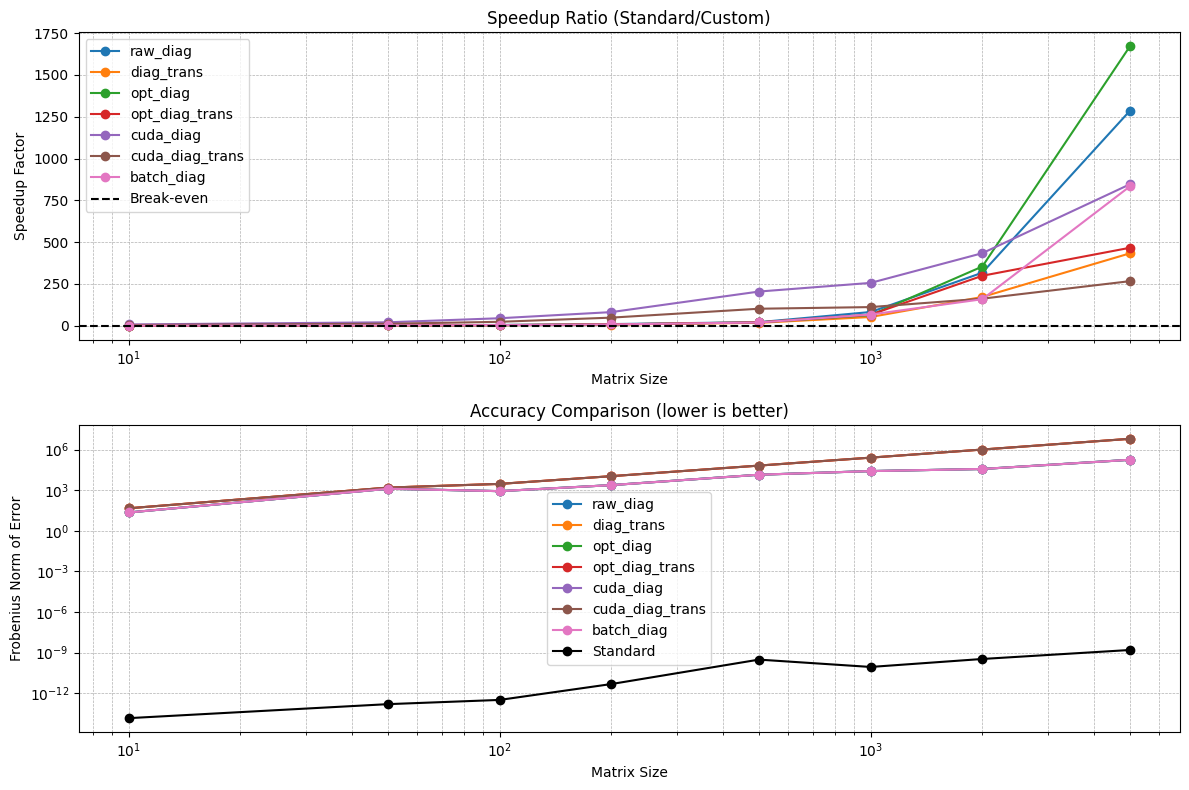

In [9]:
# Claude Raw diagonal GPU times
import numpy as np
import time
import unittest

# Try to import cupy for GPU acceleration
try:
    import cupy as cp
    HAS_CUPY = True
    print("CuPy found! GPU acceleration enabled.")
except ImportError:
    HAS_CUPY = False
    print("CuPy not found. Using NumPy with CPU only. Install CuPy for GPU acceleration.")

# --- Optimized GPU Custom Inverse Functions ---

def raw_diagonal_approx_inv_optimized(A):
    """
    Optimized diagonal approximation of the inverse.
    Directly computes 1/diag(A) and creates diagonal matrix in one step.
    """
    xp = cp if HAS_CUPY and isinstance(A, cp.ndarray) else np

    if not (isinstance(A, (np.ndarray, cp.ndarray)) and A.ndim == 2 and A.shape[0] == A.shape[1]):
        return None

    n = A.shape[0]
    result = xp.zeros_like(A)

    # Get diagonal indices directly
    idx = xp.arange(n)

    # Extract diagonal, handle zeros, and compute inverse directly at diagonal positions
    diag_elements = A[idx, idx]
    diag_elements = xp.where(diag_elements == 0, 1e-9, diag_elements)

    # Set only the diagonal elements - much faster than creating a full diagonal matrix
    result[idx, idx] = 1.0 / diag_elements

    return result

def diagonal_trans_approx_inv_optimized(A):
    """
    Optimized diagonal transpose approximation.
    Uses direct indexing instead of separate operations.
    """
    xp = cp if HAS_CUPY and isinstance(A, cp.ndarray) else np

    if not (isinstance(A, (np.ndarray, cp.ndarray)) and A.ndim == 2 and A.shape[0] == A.shape[1]):
        return None

    n = A.shape[0]
    # Create the transpose first (optimized memory access pattern)
    result = A.T.copy()

    # Get diagonal indices
    idx = xp.arange(n)

    # Extract diagonal, handle zeros, and set inverse directly
    diag_elements = A[idx, idx]
    diag_elements = xp.where(diag_elements == 0, 1e-9, diag_elements)

    # Set diagonal elements directly
    result[idx, idx] = 1.0 / diag_elements

    return result

# --- CUDA kernel implementation for even faster processing ---
if HAS_CUPY:
    # Custom CUDA kernel for diagonal inverse
    diagonal_inv_kernel = cp.ElementwiseKernel(
        'T a, int32 n', 'T out',
        '''
        if (i / n == i % n) {  // If on diagonal
            out = (a == 0) ? 1e-9 : a;
            out = 1.0 / out;
        } else {
            out = 0;
        }
        ''',
        'diagonal_inv_kernel'
    )

    # Custom CUDA kernel for diagonal-transpose approximation
    diagonal_trans_inv_kernel = cp.ElementwiseKernel(
        'T a, T at, int32 n', 'T out',
        '''
        if (i / n == i % n) {  // If on diagonal
            T diag_val = (a == 0) ? 1e-9 : a;
            out = 1.0 / diag_val;
        } else {
            out = at;  // Keep the transpose values for non-diagonal elements
        }
        ''',
        'diagonal_trans_inv_kernel'
    )

def raw_diagonal_approx_inv_cuda(A):
    """
    CUDA kernel implementation of diagonal inverse approximation.
    """
    if not HAS_CUPY:
        return raw_diagonal_approx_inv_optimized(A)

    if not (isinstance(A, cp.ndarray) and A.ndim == 2 and A.shape[0] == A.shape[1]):
        return None

    n = A.shape[0]
    # Initialize output array (zeros)
    output = cp.zeros_like(A)

    # Run CUDA kernel
    diagonal_inv_kernel(A, n, output)

    return output

def diagonal_trans_approx_inv_cuda(A):
    """
    CUDA kernel implementation of diagonal-transpose inverse approximation.
    """
    if not HAS_CUPY:
        return diagonal_trans_approx_inv_optimized(A)

    if not (isinstance(A, cp.ndarray) and A.ndim == 2 and A.shape[0] == A.shape[1]):
        return None

    n = A.shape[0]
    # Transpose A
    A_t = A.T.copy()

    # Initialize output array with transpose values
    output = cp.zeros_like(A)

    # Run CUDA kernel
    diagonal_trans_inv_kernel(A, A_t, n, output)

    return output

# --- Batched operations for even better performance ---
def raw_diagonal_approx_inv_batched(A, batch_size=1000):
    """
    Processes matrices in batches for better GPU utilization.
    Only makes sense for very large matrices.
    """
    xp = cp if HAS_CUPY and isinstance(A, cp.ndarray) else np

    if not (isinstance(A, (np.ndarray, cp.ndarray)) and A.ndim == 2 and A.shape[0] == A.shape[1]):
        return None

    n = A.shape[0]
    result = xp.zeros_like(A)

    # Process in batches for large matrices
    if n > batch_size and HAS_CUPY and isinstance(A, cp.ndarray):
        for i in range(0, n, batch_size):
            end_idx = min(i + batch_size, n)
            batch_idx = xp.arange(i, end_idx)

            # Extract diagonal batch
            diag_elements = A[batch_idx, batch_idx]
            diag_elements = xp.where(diag_elements == 0, 1e-9, diag_elements)

            # Set diagonal elements for this batch
            result[batch_idx, batch_idx] = 1.0 / diag_elements
    else:
        # For smaller matrices, use the optimized version
        idx = xp.arange(n)
        diag_elements = A[idx, idx]
        diag_elements = xp.where(diag_elements == 0, 1e-9, diag_elements)
        result[idx, idx] = 1.0 / diag_elements

    return result

# --- Unified benchmark function with memory management ---
def benchmark_matrix_inversion(sizes, custom_inv_methods, num_trials=30, warm_up=True):
    all_results_summary = []

    # Enable memory pool for better memory management
    if HAS_CUPY:
        mempool = cp.get_default_memory_pool()
        pinned_mempool = cp.get_default_pinned_memory_pool()

    # --- Construct Header ---
    header_parts = [f"{'Matrix Size':>12}"]

    # For each custom function, add time ratio, accuracy ratio, and other columns
    for name, _ in custom_inv_methods:
        header_parts.append(f"{name + ' T/Std T':>15}")  # Custom time / Standard time
        header_parts.append(f"{name + ' Acc/Std Acc':>15}")  # Custom accuracy / Standard accuracy
        header_parts.append(f"{name + ' Time (s)':>15}")
        header_parts.append(f"{name + ' Acc':>15}")
        header_parts.append(f"{name + ' Speedup':>15}")  # Standard time / Custom time

    # Add standard method columns at the end
    header_parts.append(f"{'Std Time (s)':>15}")
    header_parts.append(f"{'Std Acc':>15}")

    print(" ".join(header_parts))
    print("-" * len(" ".join(header_parts)))

    for size in sizes:
        # Generate a random square matrix
        if HAS_CUPY:
            # Create matrix directly on GPU for better performance
            A = cp.random.rand(size, size)

            # Synchronize GPU to ensure timing accuracy
            cp.cuda.Device().synchronize()
        else:
            A = np.random.rand(size, size)

        current_row_results = [f"{size:>12}"]
        custom_metrics_for_size = []

        # --- Benchmark standard inverse (NumPy or CuPy) ---
        xp = cp if HAS_CUPY else np

        # Reduce trials for large matrices
        trials_for_std = num_trials if size <= 2000 else max(1, num_trials // 3)

        # Warm-up
        if warm_up and size < 2000:
            _ = xp.linalg.inv(A)
            if HAS_CUPY:
                cp.cuda.Device().synchronize()

        # Benchmark
        start_time = time.perf_counter()
        for _ in range(trials_for_std):
            std_inv = xp.linalg.inv(A)
            if HAS_CUPY:
                cp.cuda.Device().synchronize()
        std_inv_time = (time.perf_counter() - start_time) / trials_for_std

        # Calculate accuracy
        n = A.shape[0]
        I = xp.eye(n, dtype=A.dtype)
        residual = A @ std_inv - I
        std_inv_accuracy = xp.linalg.norm(residual, 'fro')
        if HAS_CUPY:
            std_inv_accuracy = float(std_inv_accuracy.get())  # Move to CPU for comparison

        # --- Benchmark Custom Inverse Functions ---
        for cf_name, cf_func in custom_inv_methods:
            # Warm-up
            if warm_up and size < 5000:
                _ = cf_func(A)
                if HAS_CUPY:
                    cp.cuda.Device().synchronize()

            # Benchmark
            start_time = time.perf_counter()
            for _ in range(num_trials):
                custom_inv = cf_func(A)
                if HAS_CUPY:
                    cp.cuda.Device().synchronize()
            custom_inv_time = (time.perf_counter() - start_time) / num_trials

            # Calculate accuracy
            if custom_inv is not None:
                residual = A @ custom_inv - I
                custom_inv_accuracy = xp.linalg.norm(residual, 'fro')
                if HAS_CUPY:
                    custom_inv_accuracy = float(custom_inv_accuracy.get())  # Move to CPU
            else:
                custom_inv_accuracy = float('inf')

            # Calculate ratios
            time_ratio = custom_inv_time / std_inv_time if std_inv_time > 1e-12 else float('nan')
            speedup = std_inv_time / custom_inv_time if custom_inv_time > 1e-12 else float('nan')
            acc_ratio = custom_inv_accuracy / std_inv_accuracy if std_inv_accuracy > 1e-12 else float('nan')

            # Format for display
            time_ratio_str = f"{time_ratio:.4f}" if not np.isnan(time_ratio) else "N/A"
            speedup_str = f"{speedup:.2f}x" if not np.isnan(speedup) else "N/A"
            acc_ratio_str = f"{acc_ratio:.4f}" if not np.isnan(acc_ratio) else "N/A"

            # Add to results row
            current_row_results.append(f"{time_ratio_str:>15.3e}")
            current_row_results.append(f"{acc_ratio_str:>15.3e}")
            current_row_results.append(f"{custom_inv_time:>15.3e}")
            current_row_results.append(f"{custom_inv_accuracy:>15.2e}")
            current_row_results.append(f"{speedup_str:>15.3e}")

            custom_metrics_for_size.append((
                cf_name,
                custom_inv_time,
                custom_inv_accuracy,
                time_ratio,
                acc_ratio,
                speedup
            ))

        # Add NumPy/CuPy results at the end
        current_row_results.append(f"{std_inv_time:>15.6e}")
        current_row_results.append(f"{std_inv_accuracy:>15.2e}")

        print(" ".join(current_row_results))
        all_results_summary.append({
            'size': size,
            'std_inv_time': std_inv_time,
            'std_inv_accuracy': std_inv_accuracy,
            'custom_metrics': custom_metrics_for_size
        })

        # Clean up GPU memory after each size
        if HAS_CUPY:
            # Force garbage collection to free memory
            mempool.free_all_blocks()
            pinned_mempool.free_all_blocks()

    return all_results_summary

if __name__ == '__main__':
    # --- Define your custom functions to test ---
    custom_functions_to_test = [
        # Original implementations
        ("raw_diag", raw_diagonal_approx_inv),
        ("diag_trans", diagonal_trans_approx_inv),

        # Optimized implementations
        ("opt_diag", raw_diagonal_approx_inv_optimized),
        ("opt_diag_trans", diagonal_trans_approx_inv_optimized),
    ]

    # Add CUDA kernel implementations if available
    if HAS_CUPY:
        custom_functions_to_test.extend([
            ("cuda_diag", raw_diagonal_approx_inv_cuda),
            ("cuda_diag_trans", diagonal_trans_approx_inv_cuda),
            ("batch_diag", raw_diagonal_approx_inv_batched)
        ])

    # Define the matrix sizes to test (smaller step sizes for better curve)
    matrix_sizes = [10, 50, 100, 200, 500, 1000, 2000, 5000]

    print("\nStarting Benchmark...\n")

    # Pre-warm GPU for more consistent timing
    if HAS_CUPY:
        print("Pre-warming GPU...")
        warm_up_size = 1000
        A_warm = cp.random.rand(warm_up_size, warm_up_size)
        _ = cp.linalg.inv(A_warm)  # Force CUDA initialization
        cp.cuda.Device().synchronize()
        del A_warm
        cp.get_default_memory_pool().free_all_blocks()
        print("GPU warm-up complete.")

    benchmark_summary = benchmark_matrix_inversion(
        matrix_sizes,
        custom_functions_to_test,
        num_trials=20  # Reduced for broader size range testing
    )

    # Generate a visualization of the results
    try:
        import matplotlib.pyplot as plt

        sizes = [result['size'] for result in benchmark_summary]
        std_times = [result['std_inv_time'] for result in benchmark_summary]

        # Plot speedup comparison
        plt.figure(figsize=(12, 8))

        # 1. Speedup Ratio Plot
        plt.subplot(2, 1, 1)
        for func_idx, (func_name, _) in enumerate(custom_functions_to_test):
            speedup_values = [result['custom_metrics'][func_idx][5] for result in benchmark_summary]
            # Filter out NaN or inf values
            valid_points = [(s, v) for s, v in zip(sizes, speedup_values)
                          if not np.isnan(v) and v != float('inf')]

            if valid_points:
                valid_sizes, valid_speedups = zip(*valid_points)
                plt.semilogx(valid_sizes, valid_speedups, 'o-', label=func_name)

        plt.title('Speedup Ratio (Standard/Custom)')
        plt.xlabel('Matrix Size')
        plt.ylabel('Speedup Factor')
        plt.axhline(y=1, color='k', linestyle='--', label='Break-even')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()

        # 2. Accuracy Comparison
        plt.subplot(2, 1, 2)
        for func_idx, (func_name, _) in enumerate(custom_functions_to_test):
            acc_values = [result['custom_metrics'][func_idx][2] for result in benchmark_summary]
            plt.loglog(sizes, acc_values, 'o-', label=func_name)

        # Add std accuracy for comparison
        std_acc = [result['std_inv_accuracy'] for result in benchmark_summary]
        plt.loglog(sizes, std_acc, 'ko-', label='Standard')

        plt.title('Accuracy Comparison (lower is better)')
        plt.xlabel('Matrix Size')
        plt.ylabel('Frobenius Norm of Error')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()

        plt.tight_layout()
        plt.savefig('matrix_inversion_benchmark.png')
        print("\nBenchmark visualization saved as 'matrix_inversion_benchmark.png'")
    except ImportError:
        print("\nMatplotlib not available for visualization.")

    print("\nBenchmark complete!")

These cells show that matrix multiplication of the same square size is a little faster but goes down significantly with size.  Up to 30x faster on 500x500 (but probably 6x) but goes down to 2x on 5kx5k. The produces reduce to each other and have same asymptotic complexity so not a significant advantage.
Multiplying by transpose won't help unless skinny

In [ ]:
import torch
import time

# Define the device: use GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to benchmark matrix multiplication and inversion
def benchmark_matrix_operations(sizes, num_trials=10):
    results = []

    for size in sizes:
        # Generate a random square matrix of the given size
        A = torch.randn(size, size, device=device)

        # Ensure the matrix is invertible by making it diagonally dominant
        A += size * torch.eye(size, device=device)

        # Warm-up to ensure fair timing
        _ = torch.matmul(A, A)

        # Benchmark matrix multiplication
        start_time = time.time()
        for _ in range(num_trials):
            _ = torch.matmul(A, A)
        torch.cuda.synchronize() if device.type == 'cuda' else None
        matmul_time = (time.time() - start_time) / num_trials

        _ = torch.linalg.inv(A)
        # Benchmark matrix inversion
        start_time = time.time()
        for _ in range(num_trials):
            _ = torch.linalg.inv(A)
        torch.cuda.synchronize() if device.type == 'cuda' else None
        inv_time = (time.time() - start_time) / num_trials

        # Store the results
        results.append((size, matmul_time, inv_time))
        print(size, matmul_time, inv_time, matmul_time/inv_time)

    return results

# Define the matrix sizes to test
matrix_sizes = [10, 50, 100, 200, 500, 1000, 5000, 10000, 50000]

# Run the benchmark
benchmark_results = benchmark_matrix_operations(matrix_sizes, num_trials = 20)

# Display the results
print(f"{'Matrix Size':>12} {'MatMul Time (s)':>20} {'Inv Time (s)':>20} {'Mat/Inv Time':>20}")
for size, matmul_time, inv_time in benchmark_results:
    print(f"{size:>12} {matmul_time:>20.6f} {inv_time:>20.6f} {matmul_time/inv_time:>20.6f}")

# run 30
"""10 1.877148946126302e-05 0.0003227710723876953 0.058157285665041615
50 1.7730394999186196e-05 0.0003882408142089844 0.04566854990583803
100 1.5767415364583335e-05 0.0006312211354573568 0.024979225946163728
200 2.9635429382324218e-05 0.0012284676233927409 0.02412389941582512
500 0.00013500054677327474 0.004252290725708008 0.03174772269381866
1000 0.0007151126861572266 0.005622100830078125 0.12719670240195413
 Matrix Size      MatMul Time (s)         Inv Time (s)
          10             0.000019             0.000323
          50             0.000018             0.000388
         100             0.000016             0.000631
         200             0.000030             0.001228
         500             0.000135             0.004252
        1000             0.000715             0.005622"""

# run 20
"""10 2.626180648803711e-05 0.00021392107009887695 0.12276400111451659
50 1.4805793762207032e-05 0.0003893613815307617 0.03802584042618334
100 1.6188621520996095e-05 0.0006322860717773438 0.025603318250377077
200 3.0171871185302734e-05 0.0012446761131286622 0.024240740918102497
500 0.00013736486434936523 0.00461735725402832 0.0297496721159109
1000 0.0004841446876525879 0.006773900985717773 0.07147206442393654
5000 0.06700122356414795 0.13253986835479736 0.5055175050030355
10000 0.5501346826553345 0.8802123546600342 0.6250022278633136"""


10 2.626180648803711e-05 0.00021392107009887695 0.12276400111451659
50 1.4805793762207032e-05 0.0003893613815307617 0.03802584042618334
100 1.6188621520996095e-05 0.0006322860717773438 0.025603318250377077
200 3.0171871185302734e-05 0.0012446761131286622 0.024240740918102497
500 0.00013736486434936523 0.00461735725402832 0.0297496721159109
1000 0.0004841446876525879 0.006773900985717773 0.07147206442393654
5000 0.06700122356414795 0.13253986835479736 0.5055175050030355
10000 0.5501346826553345 0.8802123546600342 0.6250022278633136


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.31 GiB. GPU 0 has a total capacity of 14.74 GiB of which 4.87 GiB is free. Process 6390 has 9.87 GiB memory in use. Of the allocated memory 9.69 GiB is allocated by PyTorch, and 13.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
import torch
import time
import numpy as np

# Choose device: GPU if available, otherwise CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def benchmark_ops(size, num_trials=20, device=device):
    # Create an invertible matrix: make it diagonally dominant.
    A = torch.randn(size, size, device=device)
    A += size * torch.eye(size, device=device)

    # Warm-up
    _ = torch.matmul(A, A)

    # Benchmark matrix multiplication.
    matmul_times = []
    for _ in range(num_trials):
        start = time.time()
        C = torch.matmul(A, A)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        elapsed = time.time() - start
        matmul_times.append(elapsed)

    # Benchmark matrix inversion.
    _ = torch.linalg.inv(A)
    inv_times = []
    for _ in range(num_trials):
        start = time.time()
        B = torch.linalg.inv(A)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        elapsed = time.time() - start
        inv_times.append(elapsed)

    # Compute averages and standard error (std / sqrt(N)).
    avg_matmul = np.mean(matmul_times)
    avg_inv = np.mean(inv_times)
    se_matmul = np.std(matmul_times, ddof=1) / np.sqrt(num_trials)
    se_inv = np.std(inv_times, ddof=1) / np.sqrt(num_trials)

    # Ratio inversion / multiplication with error propagation.
    ratio = avg_inv / avg_matmul
    # Error propagation assuming independent measurements:
    # σ_ratio = ratio * sqrt((se_inv/avg_inv)^2 + (se_matmul/avg_matmul)^2)
    ratio_error = ratio * np.sqrt((se_inv/avg_inv)**2 + (se_matmul/avg_matmul)**2)

    return {
        'size': size,
        'avg_matmul': avg_matmul,
        'se_matmul': se_matmul,
        'avg_inv': avg_inv,
        'se_inv': se_inv,
        'ratio': ratio,
        'ratio_error': ratio_error
    }

def run_benchmarks(sizes, num_trials=20,device=device):
    results = []
    for s in sizes:
        res = benchmark_ops(s, num_trials=num_trials,device=device)
        results.append(res)
        print(f"Size: {s:4d} | MatMul: {res['avg_matmul']*1000:.3f} ± {res['se_matmul']*1000:.3f} ms "
              f"| Inv: {res['avg_inv']*1000:.3f} ± {res['se_inv']*1000:.3f} ms "
              f"| Ratio (Inv/MatMul): {res['ratio']:.2f} ± {res['ratio_error']:.2f}")
    return results

# Define matrix sizes to benchmark

# On GPU
if False:
  matrix_sizes = [10, 50, 100, 200, 500, 1000, 5000, 10000]
  results = run_benchmarks(matrix_sizes, num_trials=20)
"""Size:   10 | MatMul: 0.040 ± 0.006 ms | Inv: 0.329 ± 0.040 ms | Ratio (Inv/MatMul): 8.32 ± 1.57
Size:   50 | MatMul: 0.035 ± 0.004 ms | Inv: 0.430 ± 0.003 ms | Ratio (Inv/MatMul): 12.43 ± 1.35
Size:  100 | MatMul: 0.035 ± 0.002 ms | Inv: 0.668 ± 0.002 ms | Ratio (Inv/MatMul): 19.12 ± 0.99
Size:  200 | MatMul: 0.047 ± 0.001 ms | Inv: 1.279 ± 0.005 ms | Ratio (Inv/MatMul): 27.17 ± 0.77
Size:  500 | MatMul: 0.155 ± 0.002 ms | Inv: 4.716 ± 0.004 ms | Ratio (Inv/MatMul): 30.41 ± 0.35
Size: 1000 | MatMul: 0.821 ± 0.003 ms | Inv: 5.857 ± 0.303 ms | Ratio (Inv/MatMul): 7.14 ± 0.37
Size: 5000 | MatMul: 66.220 ± 0.972 ms | Inv: 138.023 ± 0.683 ms | Ratio (Inv/MatMul): 2.08 ± 0.03
Size: 10000 | MatMul: 548.567 ± 1.532 ms | Inv: 939.724 ± 3.000 ms | Ratio (Inv/MatMul): 1.71 ± 0.01"""
# up to 30x faster for 500x500 but only 2x faster for 5k x 5k

# ON CPU
matrix_sizes = [10, 50, 100, 200, 500, 1000, 5000]
cpu = torch.device('cpu')
results = run_benchmarks(matrix_sizes, num_trials=20, device=cpu)
"""Size:   10 | MatMul: 0.010 ± 0.004 ms | Inv: 0.068 ± 0.005 ms | Ratio (Inv/MatMul): 6.64 ± 2.56
Size:   50 | MatMul: 0.015 ± 0.002 ms | Inv: 0.143 ± 0.005 ms | Ratio (Inv/MatMul): 9.35 ± 1.10
Size:  100 | MatMul: 0.056 ± 0.002 ms | Inv: 0.264 ± 0.004 ms | Ratio (Inv/MatMul): 4.73 ± 0.15
Size:  200 | MatMul: 0.344 ± 0.004 ms | Inv: 0.993 ± 0.014 ms | Ratio (Inv/MatMul): 2.89 ± 0.05
Size:  500 | MatMul: 5.228 ± 0.201 ms | Inv: 9.476 ± 0.235 ms | Ratio (Inv/MatMul): 1.81 ± 0.08
Size: 1000 | MatMul: 43.976 ± 4.766 ms | Inv: 62.831 ± 5.605 ms | Ratio (Inv/MatMul): 1.43 ± 0.20
Size: 5000 | MatMul: 3221.176 ± 91.130 ms | Inv: 4450.811 ± 105.893 ms | Ratio (Inv/MatMul): 1.38 ± 0.05
"""
# cpu barely 2x faster

Size:   10 | MatMul: 0.013 ± 0.004 ms | Inv: 0.090 ± 0.007 ms | Ratio (Inv/MatMul): 6.82 ± 2.36
Size:   50 | MatMul: 0.100 ± 0.084 ms | Inv: 0.160 ± 0.011 ms | Ratio (Inv/MatMul): 1.61 ± 1.36
Size:  100 | MatMul: 0.049 ± 0.006 ms | Inv: 0.348 ± 0.041 ms | Ratio (Inv/MatMul): 7.04 ± 1.16
Size:  200 | MatMul: 0.257 ± 0.013 ms | Inv: 1.197 ± 0.095 ms | Ratio (Inv/MatMul): 4.65 ± 0.44
Size:  500 | MatMul: 3.937 ± 0.147 ms | Inv: 8.810 ± 0.250 ms | Ratio (Inv/MatMul): 2.24 ± 0.10
Size: 1000 | MatMul: 28.684 ± 0.713 ms | Inv: 56.339 ± 3.719 ms | Ratio (Inv/MatMul): 1.96 ± 0.14
Size: 5000 | MatMul: 2362.821 ± 105.983 ms | Inv: 3391.687 ± 109.451 ms | Ratio (Inv/MatMul): 1.44 ± 0.08


'Size:   10 | MatMul: 0.010 ± 0.004 ms | Inv: 0.068 ± 0.005 ms | Ratio (Inv/MatMul): 6.64 ± 2.56\nSize:   50 | MatMul: 0.015 ± 0.002 ms | Inv: 0.143 ± 0.005 ms | Ratio (Inv/MatMul): 9.35 ± 1.10\nSize:  100 | MatMul: 0.056 ± 0.002 ms | Inv: 0.264 ± 0.004 ms | Ratio (Inv/MatMul): 4.73 ± 0.15\nSize:  200 | MatMul: 0.344 ± 0.004 ms | Inv: 0.993 ± 0.014 ms | Ratio (Inv/MatMul): 2.89 ± 0.05\nSize:  500 | MatMul: 5.228 ± 0.201 ms | Inv: 9.476 ± 0.235 ms | Ratio (Inv/MatMul): 1.81 ± 0.08\nSize: 1000 | MatMul: 43.976 ± 4.766 ms | Inv: 62.831 ± 5.605 ms | Ratio (Inv/MatMul): 1.43 ± 0.20\nSize: 5000 | MatMul: 3221.176 ± 91.130 ms | Inv: 4450.811 ± 105.893 ms | Ratio (Inv/MatMul): 1.38 ± 0.05\n'